In [1]:
import jax.numpy as np
from jax import random, vmap, grad, jit
from jax.experimental import optimizers

import itertools
from functools import partial
from tqdm import trange
import numpy.random as npr
import matplotlib.pyplot as plt
import sklearn.datasets

%matplotlib inline

In [2]:
def MLP(layers):
    def init(rng_key):
        def init_layer(key, d_in, d_out):
            k1, k2 = random.split(key)
            glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
            W = glorot_stddev*random.normal(k1, (d_in, d_out))
            b = np.zeros(d_out)
            return W, b
        key, *keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[:-2], layers[1:-1]))
        # Last layer
        k1, k2 = random.split(key)
        params.append(init_layer(k1, layers[-2], layers[-1]))
        params.append(init_layer(k2, layers[-2], layers[-1]))
        return params
    def apply(params, inputs):
        for W, b in params[:-2]:
            outputs = np.dot(inputs, W) + b
            inputs = np.tanh(outputs)
        W, b = params[-1]
        mu = np.dot(inputs, W) + b
        W, b = params[-2]
        Sigma = np.dot(inputs, W) + b
        return mu, Sigma
    return init, apply

In [3]:
class VAE():
    def __init__(self, X, layers_Q, layers_P, rng_key = random.PRNGKey(0), beta = 1.0, ):
        # Normalize data
        self.Xmean, self.Xstd = X.mean(0), X.std(0)
        X = (X - self.Xmean)/self.Xstd

        # Store the normalized trainind data
        self.X = X

        # Latent dimenions
        self.Z_dim = layers_Q[-1]

        # Regularization parameter beta
        self.beta = beta

        # Initialization and evaluation functions
        self.net_Q_init, self.net_Q_apply = MLP(layers_Q)
        self.net_P_init, self.net_P_apply = MLP(layers_P)
        
        # Initialize parameters, not committing to a batch shape
        key_Q, key_P = random.split(rng_key, 2)
        net_Q_params = self.net_Q_init(key_Q)
        net_P_params = self.net_P_init(key_P)
        params = (net_Q_params, net_P_params)
                    
        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3, 
                                                                      decay_steps=2000, 
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        # Logger to monitor the loss functions
        self.KL_loss_log = []
        self.recon_loss_log = []
        self.itercount = itertools.count()


    def per_example_ELBO(self, params, batch):
        net_Q_params, net_P_params = params
        X, eps = batch
        # Encoder: q(z|x)
        Z_mu, Z_logsigma = self.net_Q_apply(net_Q_params, X)
        # Re-parametrization trick
        Z = Z_mu + eps*np.sqrt(np.exp(Z_logsigma))
        # Decoder: p(x|z)
        X_mu, X_Sigma = self.net_P_apply(net_P_params, Z)
        # KL[q(z|x)||p(z)]        
        KL_loss = 0.5*np.sum(np.exp(Z_logsigma) + Z_mu**2 - 1.0 - Z_logsigma)
        # -log p(x|z): Gaussian likelihood
        recon_loss = 0.5*np.sum((X-X_mu)**2/np.exp(X_Sigma) + X_Sigma + np.log(2.0*np.pi))
        return recon_loss, KL_loss

    def loss(self, params, batch):
        pe_loss = lambda x: self.per_example_ELBO(params, x)
        recon_loss, KL_loss = vmap(pe_loss)(batch)
        loss = self.beta*KL_loss + recon_loss
        return np.mean(loss)

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, batch)
        return self.opt_update(i, g, opt_state)

    def data_stream(self, n, num_batches, batch_size):
        rng = npr.RandomState(0)
        while True:
            perm = rng.permutation(n)
            for i in range(num_batches):
                batch_idx = perm[i*batch_size:(i+1)*batch_size]
                eps = random.normal(random.PRNGKey(i), (batch_idx.shape[0], self.Z_dim))
                yield self.X[batch_idx, :], eps

    def train(self, num_epochs = 100, batch_size = 64):   
        # Build a data iterator
        n = self.X.shape[0]
        num_complete_batches, leftover = divmod(n, batch_size)
        num_batches = num_complete_batches + bool(leftover) 
        batch = iter(self.data_stream(n, num_batches, batch_size))
        # Run training loop
        pbar = trange(num_epochs)
        for epoch in pbar:
            for i in range(num_batches):
                self.opt_state = self.step(next(self.itercount), self.opt_state, next(batch))
            params = self.get_params(self.opt_state)
            pe_loss = lambda x: self.per_example_ELBO(params, x)
            recon_loss, KL_loss = vmap(pe_loss)(next(batch))
            recon_loss = np.mean(recon_loss) 
            KL_loss = np.mean(KL_loss) 
            self.KL_loss_log.append(KL_loss)
            self.recon_loss_log.append(recon_loss)
            pbar.set_postfix({'Reconstruction loss': recon_loss, 'KL loss': KL_loss})

    # Encode a single input point
    @partial(jit, static_argnums=(0,))
    def encode(self, params, X):
        net_Q_params, _ = params
        # Encoder: q(z|x)
        X = (X - self.Xmean)/self.Xstd
        Z_mu, Z_logsigma = self.net_Q_apply(net_Q_params, X)
        return Z_mu, np.exp(Z_logsigma)

    # Decode a single latent point
    @partial(jit, static_argnums=(0,))
    def decode(self, params, Z):
        _, net_P_params = params
        # Decoder: p(x|z)
        X_mu, _ = self.net_P_apply(net_P_params, Z)
        # De-normalize
        X_mu = X_mu * self.Xstd + self.Xmean
        return X_mu

    # Reconstruct a single input point
    @partial(jit, static_argnums=(0,))
    def reconstruct(self, rng_key, params, X): 
        net_Q_params, net_P_params = params
        # Encoder: q(z|x)
        X = (X - self.Xmean)/self.Xstd
        Z_mu, Z_logsigma = self.net_Q_apply(net_Q_params, X)    
        # Re-parametrization trick
        eps = random.normal(rng_key, (self.Z_dim,))
        Z = Z_mu + eps*np.sqrt(np.exp(Z_logsigma))
        # Decoder: p(x|z)
        X_mu, _ = self.net_P_apply(net_P_params, Z)
        # De-normalize
        X_mu = X_mu * self.Xstd + self.Xmean
        return X_mu

    # Generate a single sample
    @partial(jit, static_argnums=(0,))
    def generate(self, rng_key, params):
        _, net_P_params = params
        eps = random.normal(rng_key, (self.Z_dim,))
        X_mu, X_Sigma = self.net_P_apply(net_P_params, eps)
        X = random.multivariate_normal(rng_key, X_mu, np.diag(np.exp(X_Sigma)))
        X = X * self.Xstd + self.Xmean
        return X

In [4]:
# Load Iris data-set
X = sklearn.datasets.load_iris().data
y = sklearn.datasets.load_iris().target

In [5]:
# Model creation
Z_dim = 2
X_dim = X.shape[1]
init_key = random.PRNGKey(0)
layers_P = np.array([Z_dim,50,50,X_dim])
layers_Q = np.array([X_dim,50,50,Z_dim])  
model = VAE(X, layers_Q, layers_P, init_key)

In [6]:
model.train(num_epochs = 2000, batch_size = 256)

100%|██████████| 2000/2000 [01:17<00:00, 25.74it/s, Reconstruction loss=-0.5867232, KL loss=2.811238]


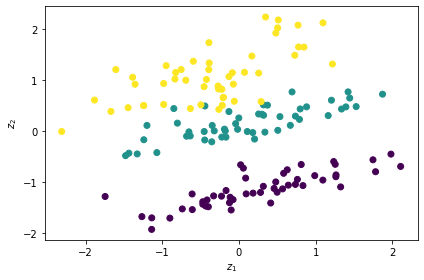

In [11]:
# Encode data and visualize the latent space
opt_params = model.get_params(model.opt_state)
enc_fn = lambda x: model.encode(opt_params, x)
z_mu, z_std = vmap(enc_fn)(X)

plt.figure(1)
plt.scatter(z_mu[:,0],z_mu[:,1], c = y)
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.tight_layout()

In [13]:
# Generate new samples
num_samples = 2000
keys = random.split(random.PRNGKey(0), num_samples)
gen_fn = lambda key: model.generate(key, opt_params)
x_star = vmap(gen_fn)(keys)

(2000, 4)


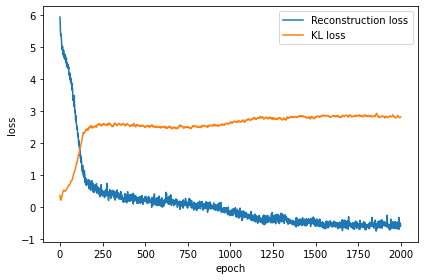

In [16]:
# Plot convergence
plt.figure()
plt.plot(model.recon_loss_log, label = 'Reconstruction loss')
plt.plot(model.KL_loss_log, label = 'KL loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.tight_layout()